In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, make_scorer, precision_recall_curve, roc_curve, auc


# Frame the Problem and Look at the Big Picture

### Define the Objective in Business Terms
The objective is to develop a predictive model to identify fraudulent credit card transactions from a given dataset. This model aims to support financial institutions or payment processors in detecting and preventing fraud in real time, reducing financial losses and protecting customer accounts. The model should focus on prioritizing possible fraudulent transactions but still make sure that it is able to identify true fraudulent transactions as not to inconvenience customers.

### How Will Your Solution Be Used?
The solution will be implemented as part of the transaction processing system, providing real-time fraud classification. When a transaction is flagged as fraudulent, it will either be declined or sent for manual review by a fraud analyst. The client will use the model to improve their fraud detection efficiency, reduce reliance on manual reviews, and maintain customer trust by proactively addressing security concerns.

### What Are the Current Solutions/Workarounds (If Any)?
Currently, most fraud detection systems use rule-based engines that rely on predefined thresholds (e.g., large transactions or unusual locations). While effective to a degree, these systems often struggle with adapting to evolving fraud patterns and result in high false-positive rates. Manual reviews are used to address flagged transactions, which can be labor-intensive, slow, and costly.

### How Should You Frame This Problem?
This is a supervised binary classification problem where the goal is to classify each transaction as either "fraudulent" or "non-fraudulent" based on labeled historical data. The model will likely be deployed in an batch learning setting, because we could update the model in a certain timeframe as opposed to online learning where it is possible to use as well, but would need to be closely inspected as it could potentially inconvience customers where precision and/or recall could decrease. 

## How Should Performance Be Measured?
- **Metrics:**
  - Precision: To ensure flagged transactions are truly fraudulent, minimizing inconvenience to customers.
  - Recall (Prioritize): To catch as many fraudulent transactions as possible.
  - F1 Score: To balance precision and recall.
  - ROC-AUC: To evaluate overall classifier performance.

### Is the Performance Measure Aligned with the Business Objective?
Yes, the performance measures align with the business objective of reducing fraud while maintaining a positive customer experience. Emphasis should be placed on recall to ensure fraud is detected, but precision is also critical to prevent disruption for legitimate customers.

### What Would Be the Minimum Performance Needed to Reach the Business Objective?
The model must outperform the current rule-based system in terms of fraud detection rate while maintaining or improving the false-positive rate. For example, achieving at least 90% recall with a precision above 80% might be a realistic goal to satisfy business requirements.

### What Are Comparable Problems? Can You Reuse Experience or Tools?
- Comparable problems include the **Squirrel Prediction Model** and **Early Spring Prediction Model**, as they both involved working with a binary classification problem.
- Tools such as the **DBScan algorithm** used in the Squirrel model might be useful to find clusters as well as other clustering algorithms used in previous works such the notebook **Clustering**.

### Is Human Expertise Available?
Human expertise is available in the form of fraud analysts who currently review flagged transactions. Their domain knowledge can guide feature selection and model validation. Analysts can also provide labeled data to improve model performance and adapt it to emerging fraud trends.

### How Would You Solve the Problem Manually?
Manual fraud detection involves analyzing transaction patterns for anomalies such as:
- Unusual transaction locations or times.
- Large transaction amounts.
- Multiple small transactions in a short time span.  
Analysts would cross-reference transaction data with customer profiles and historical behaviors to assess risk. While effective for small datasets, this approach is impractical for high transaction volumes due to its inefficiency and susceptibility to human error.

### List the Assumptions You Have Made So Far (Verify if Possible)
The dataset is assumed to accurately represent real-world fraud patterns, containing sufficiently labeled examples of both fraudulent and non-fraudulent transactions. It is expected that fraudulent transactions make up only a small proportion compared to non-fraudulent ones. The features in the dataset, such as transaction amount, location, and time, are presumed to be predictive of fraud, with fraudulent transactions exhibiting distinguishable patterns from legitimate ones. Given the imbalance in the dataset, stratification will be necessary to ensure proper representation of both classes during training. This assumption is supported by the observation that fraudulent transactions are only a small fraction of the total samples.

In [2]:
# function to concat fraudTest.csv and fraudTrain.csv datasets

def concat_data():
    # read the datasets
    fraudTest = pd.read_csv('fraudTest.csv')
    fraudTrain = pd.read_csv('fraudTrain.csv')
    # concat the datasets
    data = pd.concat([fraudTrain, fraudTest], axis=0)
    return data



In [3]:
data = concat_data()

In [4]:
#search for NAN values

data.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud               i

In [6]:
data.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,5.371934e+05,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03
std,3.669110e+05,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00
25%,2.315490e+05,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00
50%,4.630980e+05,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00
75%,8.335758e+05,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [7]:
data["is_fraud"].value_counts()

is_fraud
0    1842743
1       9651
Name: count, dtype: int64

The original dataset gave us a train and test set obviously consisting of the same variables. We decided to recombine them and split them ourselves just to make sure the splitting was random.

No NA values in the data. This is a very clean dataset and makes the cleaning the data section way easier.

23 features. A decent amount. Just looking at the feature names I want to look deeper into what merchant, amt, Unnamed, trans_num, and unix_time are.

11 of our features are numbers, only a few of them should actually be treated like that though (ie. lat and long should not be scaled or anything).

Target label is is_fraud. There are obviously a lot more cases of not being fraud over fraud.  This is the only feature we will stratify on as it is a classification problem and the target label has to be stratified ALWAYS.


In [8]:
# stratify on is_fraud to have the same proportion of fraud in train and test set take 20% of the data for the test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["is_fraud"]), data["is_fraud"], test_size=0.2, stratify=data["is_fraud"], random_state=42)

In [9]:
# train set

train = X_train.copy()
train['is_fraud'] = y_train

array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'cc_num'}>,
        <Axes: title={'center': 'amt'}>],
       [<Axes: title={'center': 'zip'}>, <Axes: title={'center': 'lat'}>,
        <Axes: title={'center': 'long'}>],
       [<Axes: title={'center': 'city_pop'}>,
        <Axes: title={'center': 'unix_time'}>,
        <Axes: title={'center': 'merch_lat'}>],
       [<Axes: title={'center': 'merch_long'}>,
        <Axes: title={'center': 'is_fraud'}>, <Axes: >]], dtype=object)

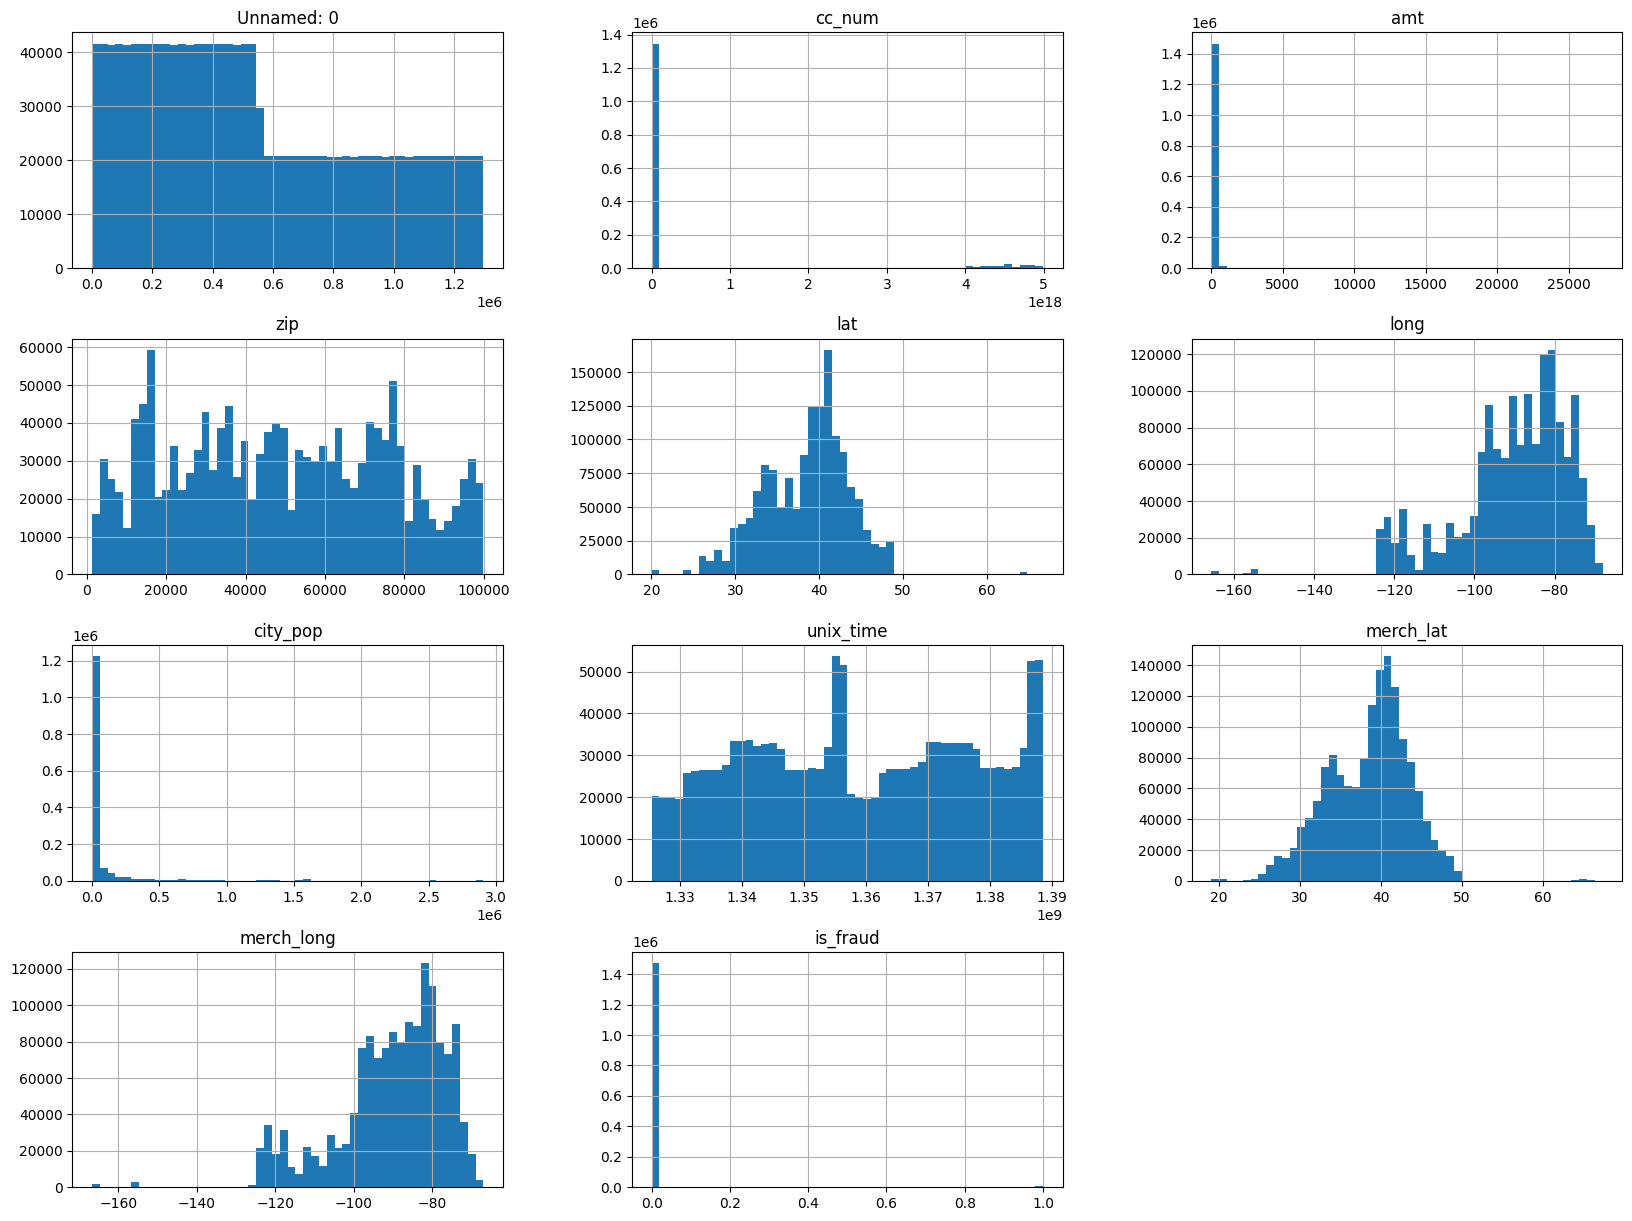

In [10]:
#histogram of train set

train.hist(bins=50, figsize=(20,15))

# Data Exploration

In [11]:
pd.set_option('display.max_columns', None)
train.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
477236,477236,2020-12-14 15:46:05,2296006538441789,"fraud_Romaguera, Wehner and Tromp",kids_pets,75.72,Judy,Hogan,F,4970 Michelle Burgs,Brooklyn,NY,11217,40.6816,-73.9798,2504700,Medical sales representative,1999-09-01,f3ec1b317f8349cba0f3c9a703d62380,1387035965,40.443492,-73.439422,0
60683,60683,2019-02-05 10:26:00,6011393492413821,fraud_Rodriguez Group,gas_transport,79.74,Natalie,Watson,F,386 James Roads Apt. 233,Los Angeles,CA,90014,34.0443,-118.2509,2383912,"Journalist, newspaper",1959-05-30,1b38e2f8f5b9e06f91ec7b26c49fbae3,1328437560,33.672410,-117.663817,0
1062243,1062243,2020-03-16 20:45:41,3534330126107879,fraud_Botsford PLC,home,74.92,Jeffrey,Smith,M,713 Scott Pike Apt. 712,Bridger,MT,59014,45.2857,-108.9082,1446,Chartered loss adjuster,1978-01-15,9cd27175f437f6e279a4dedbf1e2c230,1363466741,45.469725,-109.723735,0
341727,341727,2020-10-31 00:42:17,4587657402165341815,fraud_Huels-Nolan,gas_transport,44.30,Amber,Lewis,F,6296 John Keys Suite 858,Pembroke Township,IL,60958,41.0646,-87.5917,2135,"Psychotherapist, child",2004-05-08,ee8213aeeeb105799e00f814fc1435a4,1383180137,40.528089,-87.904092,0
279211,279211,2020-10-03 18:47:19,4990494243023,fraud_Kutch-Wilderman,home,28.02,Martin,Ford,M,56812 Francis Courts,Corriganville,MD,21524,39.6967,-78.8031,626,Energy engineer,1960-12-13,c7f2ec97abb08907c237f4ddf51e16b6,1380826039,39.564020,-79.624007,0


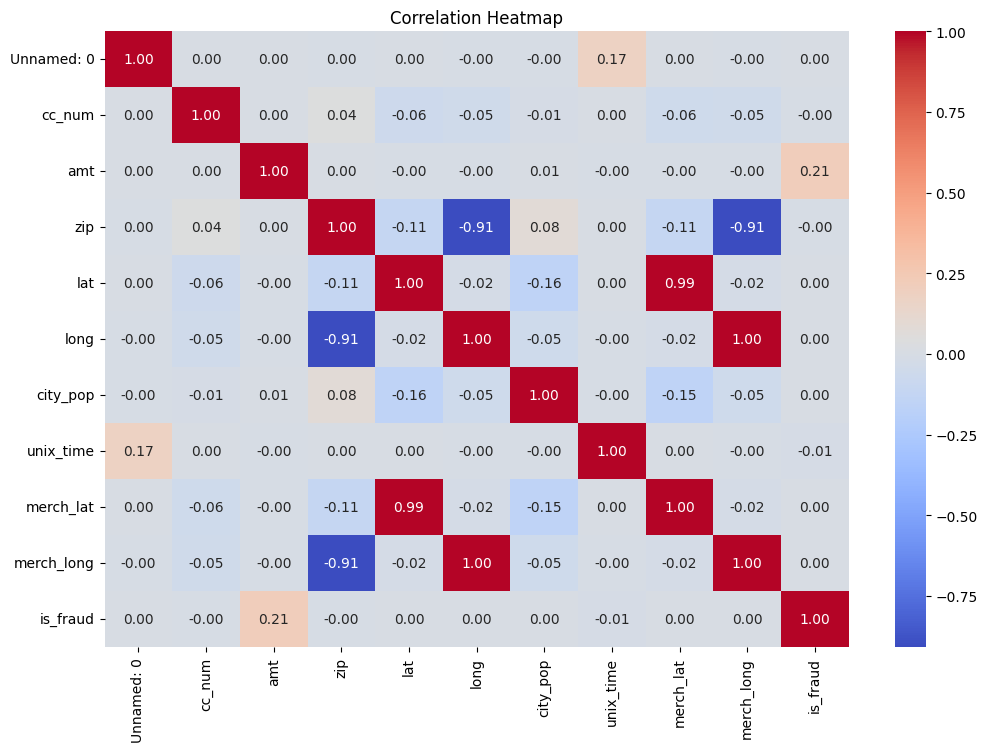

In [12]:
# Select only numerical columns
numerical_cols = train.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numerical_cols.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

From this correlation heatmap alone, there is a fair correlation with the `amt` feature. Might want to explore further to see any more correlations from within. 

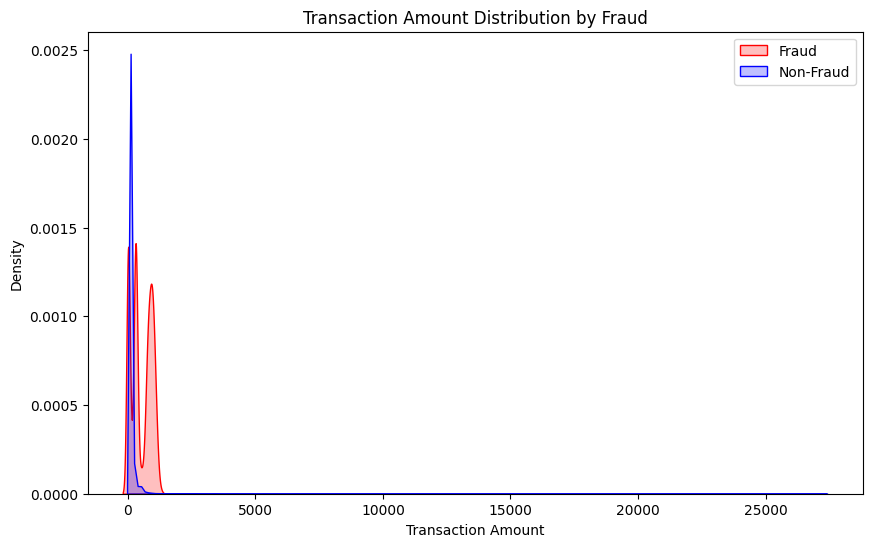

In [13]:
# Separate fraud and non-fraud transactions
fraud = train[train['is_fraud'] == 1]
non_fraud = train[train['is_fraud'] == 0]

# Plot distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(fraud['amt'], fill=True, label='Fraud', color='red')
sns.kdeplot(non_fraud['amt'], fill=True, label='Non-Fraud', color='blue')
plt.title('Transaction Amount Distribution by Fraud')
plt.xlabel('Transaction Amount')
plt.legend()
plt.show()

In [14]:
print("Fraud Transaction Stats:\n", fraud['amt'].describe())
print("\nNon-Fraud Transaction Stats:\n", non_fraud['amt'].describe())

Fraud Transaction Stats:
 count    7721.000000
mean      529.005084
std       391.470473
min         1.060000
25%       230.350000
50%       391.430000
75%       901.830000
max      1376.040000
Name: amt, dtype: float64

Non-Fraud Transaction Stats:
 count    1.474194e+06
mean     6.761816e+01
std      1.508884e+02
min      1.000000e+00
25%      9.610000e+00
50%      4.725000e+01
75%      8.251000e+01
max      2.739012e+04
Name: amt, dtype: float64


           log_amt  is_fraud
log_amt   1.000000  0.113536
is_fraud  0.113536  1.000000


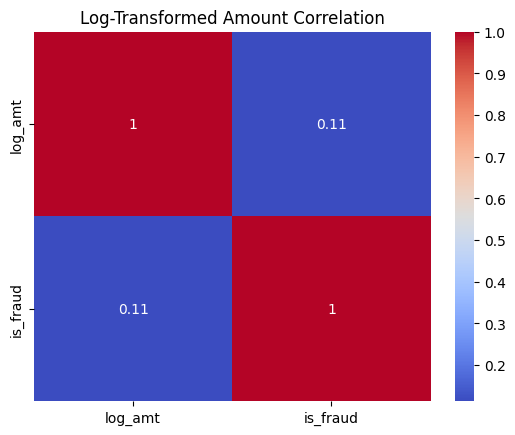

In [15]:
train['log_amt'] = train['amt'].apply(lambda x: np.log1p(x))

# Plot correlation after transformation
correlation_matrix = train[['log_amt', 'is_fraud']].corr()
print(correlation_matrix)

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Log-Transformed Amount Correlation")
plt.show()

amt_bin
Very Low     0.002194
Low          0.000119
Medium       0.008923
High         0.214888
Very High    0.219110
Name: is_fraud, dtype: float64


/var/folders/l0/dbmbcpc16f56gkfqr8z2mvym0000gp/T/ipykernel_80258/2101281669.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_bin = train.groupby('amt_bin')['is_fraud'].mean()


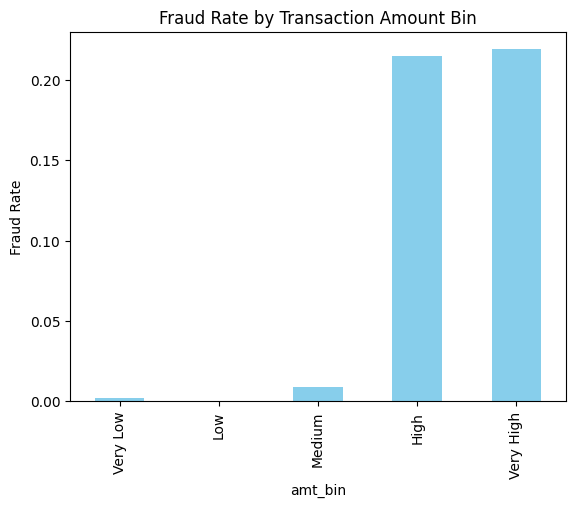

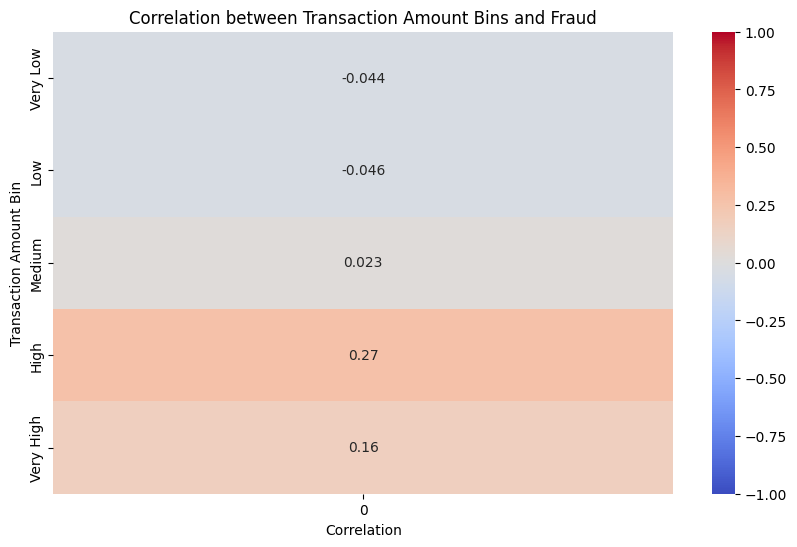

In [16]:
train['amt_bin'] = pd.cut(train['amt'], bins=[0, 50, 100, 500, 1000, float('inf')], labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Fraud rate by bin
fraud_rate_by_bin = train.groupby('amt_bin')['is_fraud'].mean()
print(fraud_rate_by_bin)

# Bar plot
fraud_rate_by_bin.plot(kind='bar', color='skyblue')
plt.title("Fraud Rate by Transaction Amount Bin")
plt.ylabel("Fraud Rate")
plt.show()
# Calculate correlation between amt_bin and is_fraud
amt_bin_corr = pd.get_dummies(train['amt_bin']).corrwith(train['is_fraud'])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(amt_bin_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation between Transaction Amount Bins and Fraud")
plt.xlabel("Correlation")
plt.ylabel("Transaction Amount Bin")
plt.show()

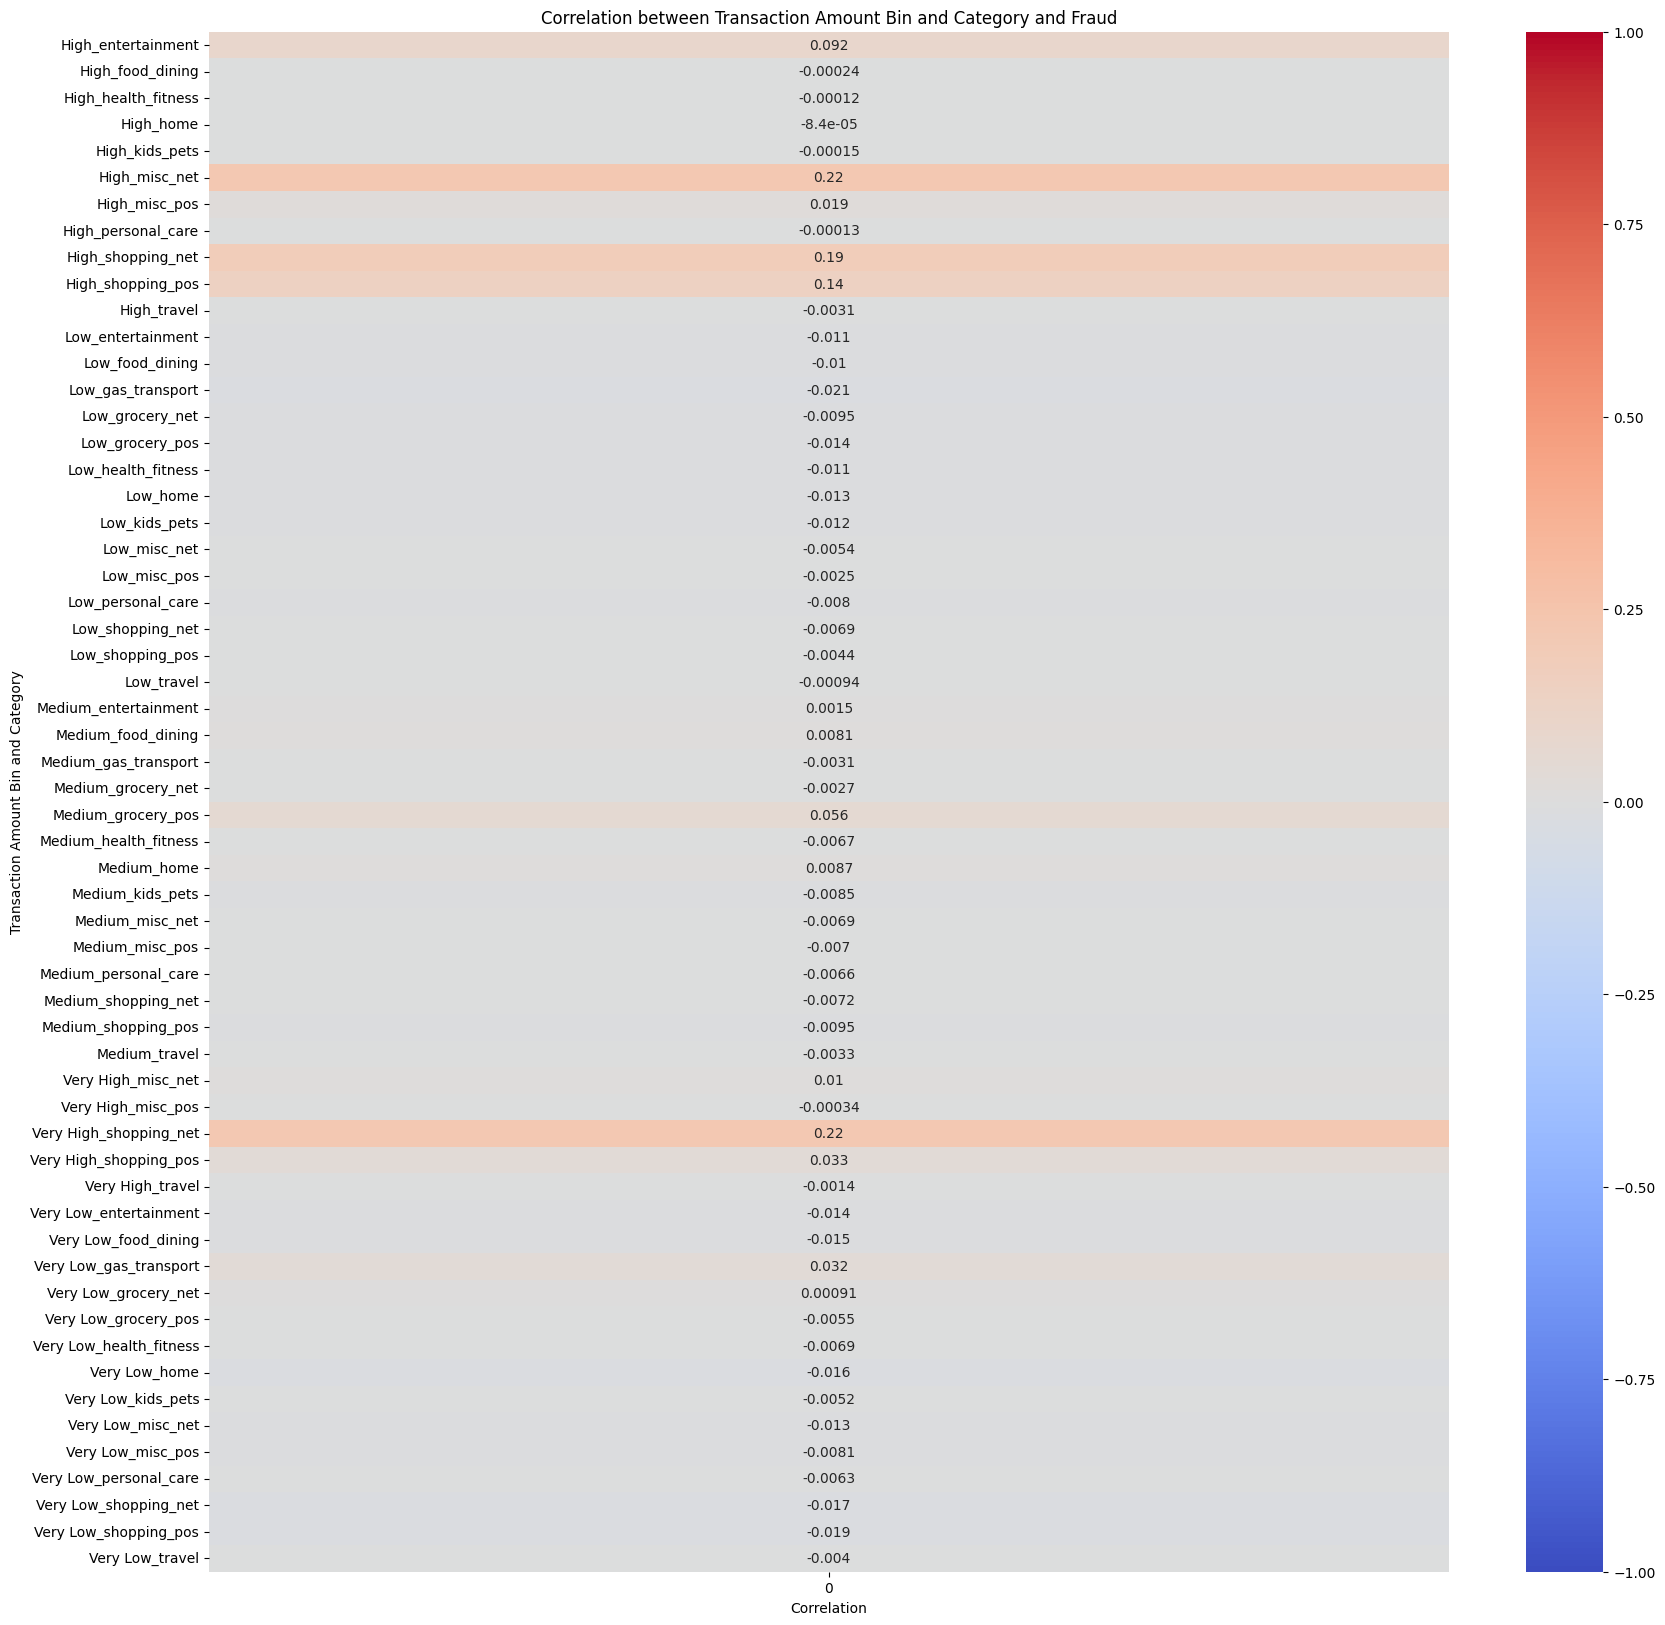

In [17]:
# Create a new feature combining amt_bin and category
train['amt_bin_category'] = train['amt_bin'].astype(str) + '_' + train['category']

# Calculate correlation between amt_bin_category and is_fraud
amt_bin_category_corr = pd.get_dummies(train['amt_bin_category']).corrwith(train['is_fraud'])

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(amt_bin_category_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation between Transaction Amount Bin and Category and Fraud")
plt.xlabel("Correlation")
plt.ylabel("Transaction Amount Bin and Category")
plt.show()

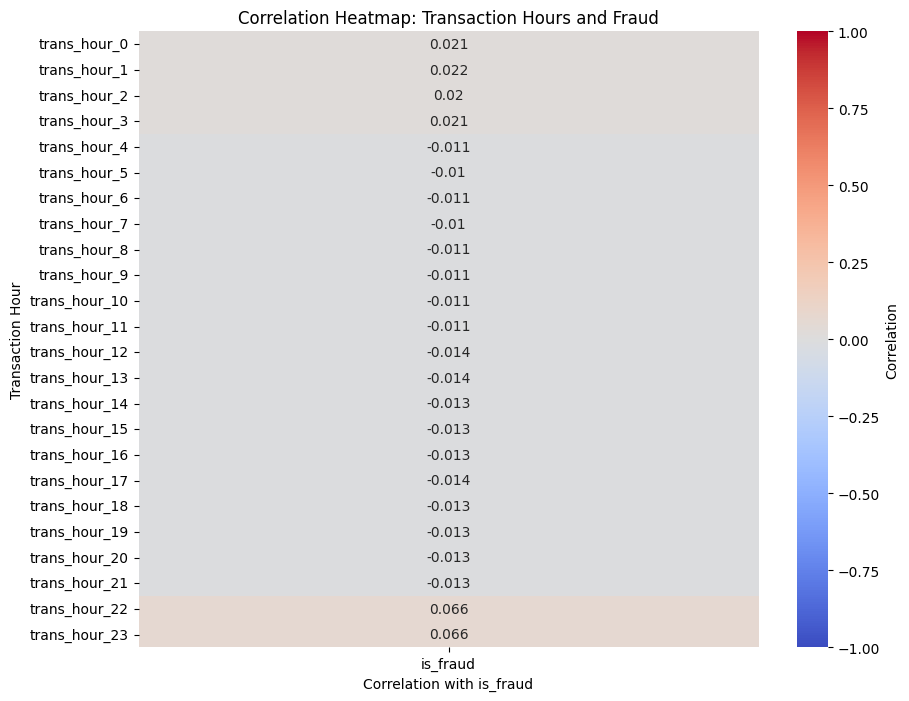

In [18]:
# Convert 'trans_date_trans_time' to datetime format
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])

# Extract hour of the transaction
train['trans_hour'] = train['trans_date_trans_time'].dt.hour

# Create binary columns for each hour (trans_hour_0, trans_hour_1, ..., trans_hour_23)
for hour in range(24):
    train[f'trans_hour_{hour}'] = (train['trans_hour'] == hour).astype(int)

# Calculate correlations with 'is_fraud'
hour_columns = [f'trans_hour_{hour}' for hour in range(24)]
correlation_matrix = train[hour_columns + ['is_fraud']].corr()

# Extract only the correlations of trans_hour features with 'is_fraud'
correlation_with_fraud = correlation_matrix.loc[hour_columns, 'is_fraud']

# Plot heatmap of the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_with_fraud.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Heatmap: Transaction Hours and Fraud')
plt.yticks(rotation=0)
plt.xlabel('Correlation with is_fraud')
plt.ylabel('Transaction Hour')
plt.show()

In [19]:
date_range = data['trans_date_trans_time'].agg(['min', 'max'])
print(date_range)

min    2019-01-01 00:00:18
max    2020-12-31 23:59:34
Name: trans_date_trans_time, dtype: object


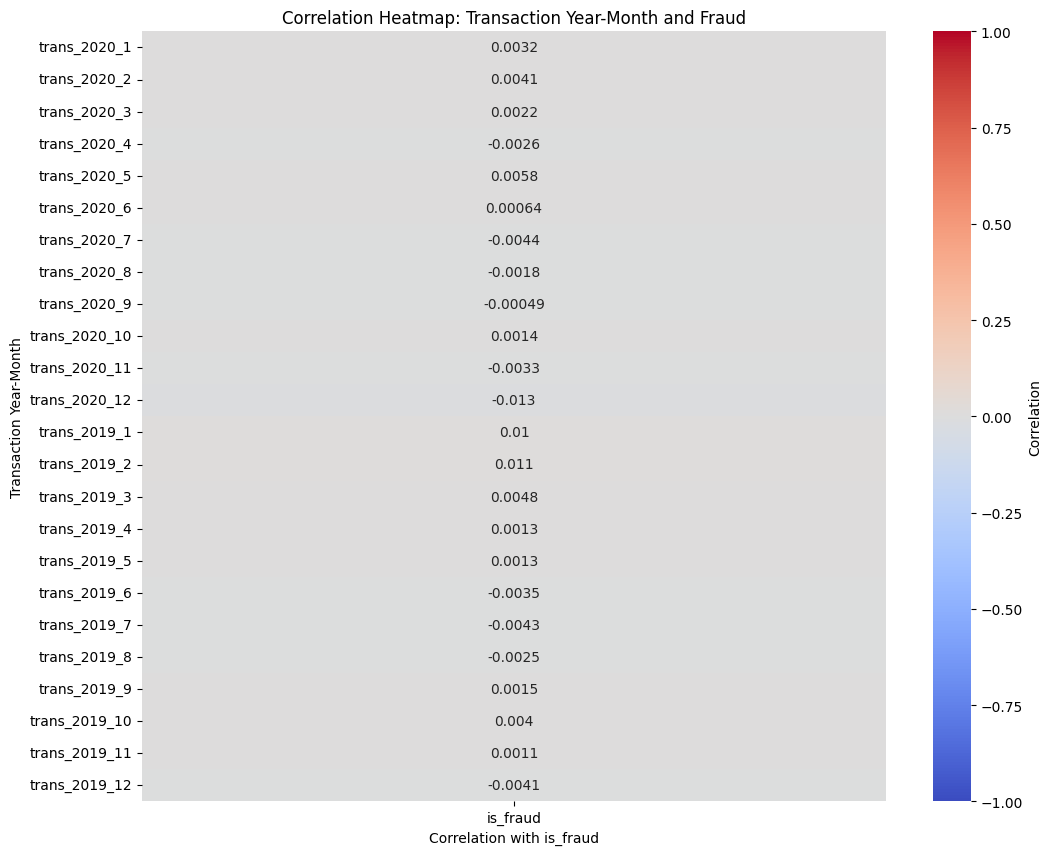

In [20]:
# Extract year and month from 'trans_date_trans_time'
train['trans_year'] = train['trans_date_trans_time'].dt.year
train['trans_month'] = train['trans_date_trans_time'].dt.month

# Create binary columns for each combination of year and month (e.g., trans_2019_1, trans_2019_2, ..., trans_2020_12)
for year in train['trans_year'].unique():
    for month in range(1, 13):
        train[f'trans_{year}_{month}'] = ((train['trans_year'] == year) & (train['trans_month'] == month)).astype(int)

# Calculate correlations with 'is_fraud'
year_month_columns = [f'trans_{year}_{month}' for year in train['trans_year'].unique() for month in range(1, 13)]
correlation_matrix = train[year_month_columns + ['is_fraud']].corr()

# Extract only the correlations of year_month features with 'is_fraud'
correlation_with_fraud = correlation_matrix.loc[year_month_columns, 'is_fraud']

# Plot heatmap of the correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_with_fraud.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Heatmap: Transaction Year-Month and Fraud')
plt.yticks(rotation=0)
plt.xlabel('Correlation with is_fraud')
plt.ylabel('Transaction Year-Month')
plt.show()

is_fraud         1
gender            
F         0.004849
M         0.005647


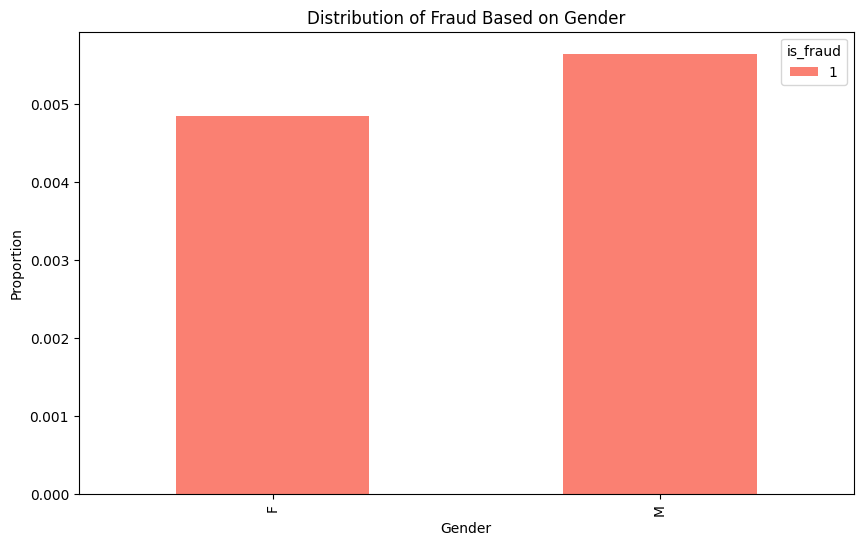

In [21]:
# Create a table to see the distribution of is_fraud based on gender
fraud_gender_table = pd.crosstab(train['gender'], train['is_fraud'], normalize='index')

# Display only the fraud column
fraud_only_table = fraud_gender_table[[1]]

# Display the table
print(fraud_only_table)

# Plot the bar graph
fraud_only_table.plot(kind='bar', figsize=(10, 6), color='salmon')
plt.title('Distribution of Fraud Based on Gender')
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.show()

It is shown that males have a higher count of fraudulent transactions compared to females.

## Correlation with times and days
Will begin to look into the times and days and see if there is any correlation that can be used with a combination of other features that could give us more insight on what could give us more correlation to out target label. 

In [22]:
# Convert 'trans_date_trans_time' to datetime format if not already done
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])

# Extract week, month, day, hour, minute, and second
train['trans_week'] = train['trans_date_trans_time'].dt.isocalendar().week
train['trans_month'] = train['trans_date_trans_time'].dt.month
train['trans_day'] = train['trans_date_trans_time'].dt.day
train['trans_hour'] = train['trans_date_trans_time'].dt.hour
train['trans_minute'] = train['trans_date_trans_time'].dt.minute
train['trans_second'] = train['trans_date_trans_time'].dt.second

# Display the first few rows to verify the new features
train[['trans_date_trans_time', 'trans_week', 'trans_month', 'trans_day', 'trans_hour', 'trans_minute', 'trans_second']].head()

,trans_date_trans_time,trans_week,trans_month,trans_day,trans_hour,trans_minute,trans_second
477236,2020-12-14 15:46:05,51,12,14,15,46,5
60683,2019-02-05 10:26:00,6,2,5,10,26,0
1062243,2020-03-16 20:45:41,12,3,16,20,45,41
341727,2020-10-31 00:42:17,44,10,31,0,42,17
279211,2020-10-03 18:47:19,40,10,3,18,47,19


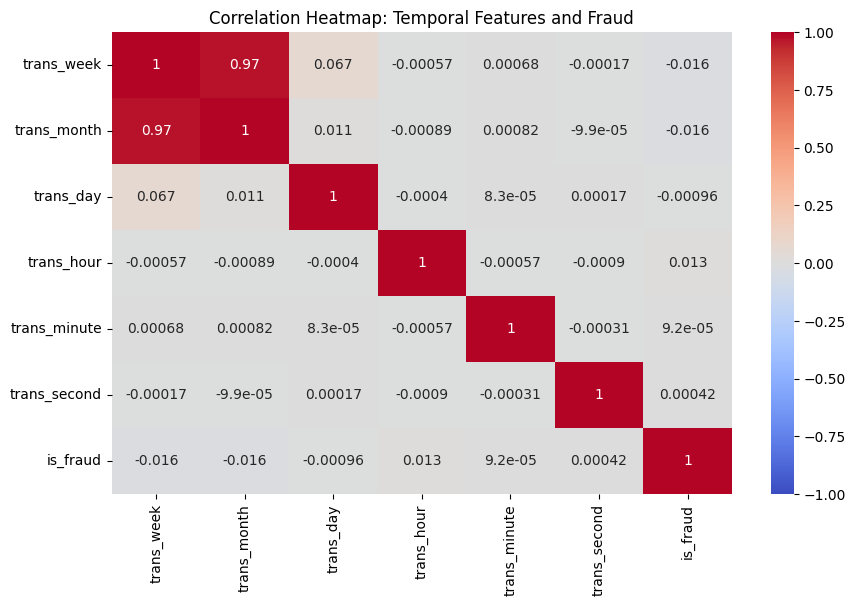

In [23]:
# Select temporal features and the target variable
temporal_features = ['trans_week', 'trans_month', 'trans_day', 'trans_hour', 'trans_minute', 'trans_second', 'is_fraud']

# Compute correlations
correlation_matrix = train[temporal_features].corr()

# Plot correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Temporal Features and Fraud')
plt.show()


There doesn't seem to be any linear correlation with the time and day features, but that was within expectation, although it didn't hurt to check.

Now we wil check if there are specific days where fraud is most likely to occur. 

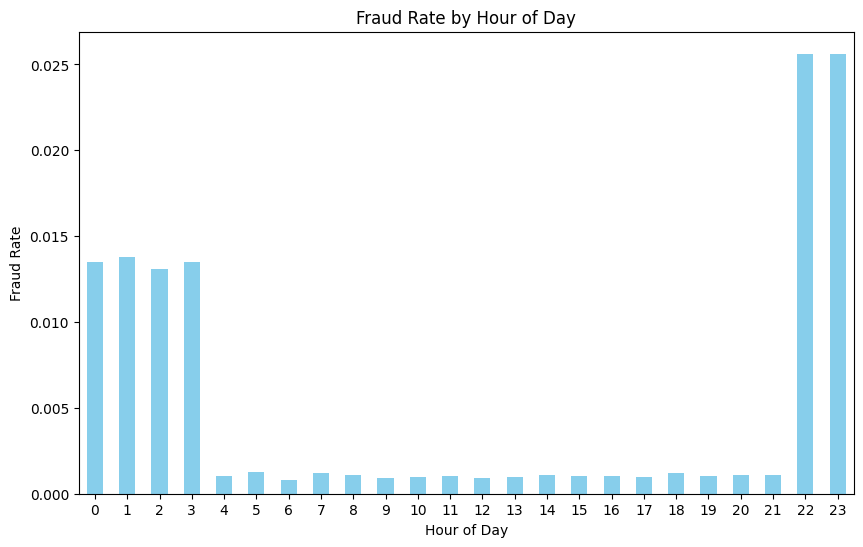

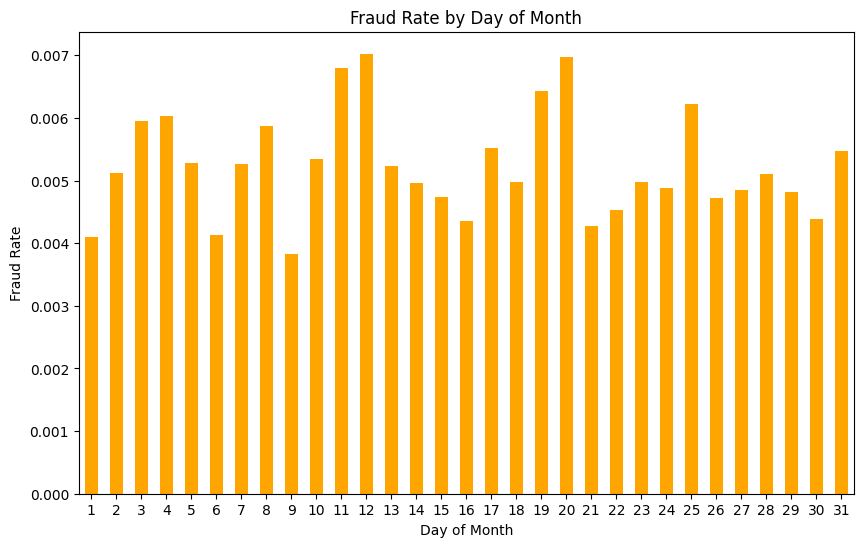

In [24]:
# Fraud rate by hour
fraud_by_hour = train.groupby('trans_hour')['is_fraud'].mean()
fraud_by_hour.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=0)
plt.show()

# Fraud rate by day
fraud_by_day = train.groupby('trans_day')['is_fraud'].mean()
fraud_by_day.plot(kind='bar', color='orange', figsize=(10, 6))
plt.title('Fraud Rate by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=0)
plt.show()


## Analysis of Fraud Rate by Hour of Day

### Overview
The analysis of fraud rates by hour of day reveals a clear pattern of elevated fraudulent activity during specific hours. Understanding these temporal trends is critical for developing targeted fraud detection strategies.

### Key Observations
1. **Peak Fraud Hours:**
   - The **highest fraud rates occur between 10 PM and 11 PM**, indicating a significant spike in fraudulent activity during these hours.
   - Following this peak, fraud rates remain **consistently high from 12 AM to 3 AM**, albeit slightly lower than the 10-11 PM window.

2. **Lower Fraud Hours:**
   - Fraudulent activity drops sharply during **daytime hours**, with the lowest rates observed between **6 AM and 8 PM**.
   - These hours likely represent periods of routine and legitimate transaction behavior.

3. **Behavioral Insights:**
   - The elevated fraud rates during late-night hours (10 PM - 3 AM) suggest that fraudsters exploit this timeframe, possibly due to reduced monitoring or system vulnerabilities.


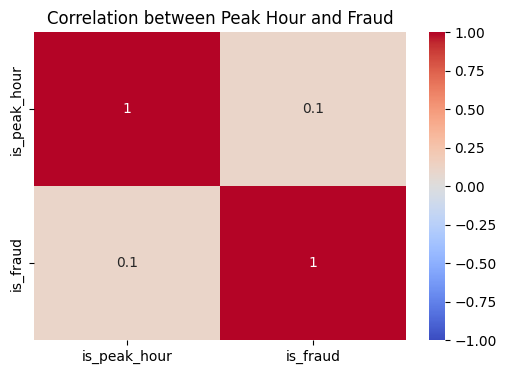

In [33]:
# Create a binary feature for transactions between 10 PM and 3 AM
train['is_peak_hour'] = train['trans_hour'].apply(lambda x: 1 if x >= 22 or x <= 3 else 0)

# Calculate the correlation between the new feature and the target label
peak_hour_corr = train[['is_peak_hour', 'is_fraud']].corr()

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(peak_hour_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Peak Hour and Fraud')
plt.show()

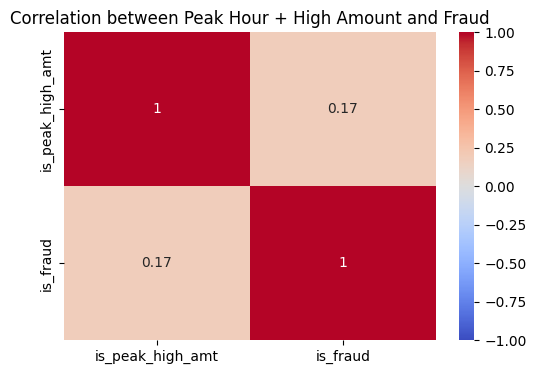

In [35]:
# Define a threshold for high transaction amounts (e.g., 75th percentile)
amt_threshold = train['amt'].quantile(0.75)

# Create combined feature
train['is_peak_high_amt'] = ((train['is_peak_hour'] == 1) & (train['amt'] > amt_threshold)).astype(int)

# Calculate correlation
combined_corr = train[['is_peak_high_amt', 'is_fraud']].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(combined_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Peak Hour + High Amount and Fraud')
plt.show()


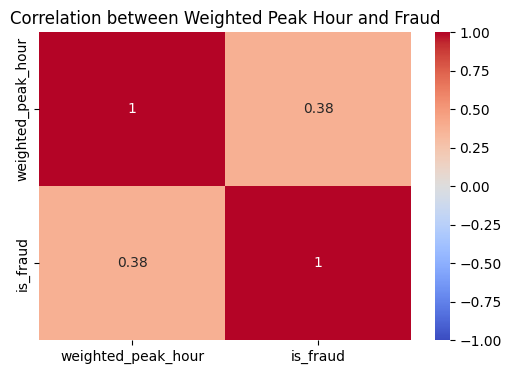

In [37]:
# Weighted peak hour feature
train['weighted_peak_hour'] = train['is_peak_hour'] * train['amt']

# Calculate correlation
weighted_corr = train[['weighted_peak_hour', 'is_fraud']].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(weighted_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Weighted Peak Hour and Fraud')
plt.show()


## Analysis of Weighted Peak Hour Feature

The `weighted_peak_hour` feature was created by combining the `is_peak_hour` feature (a binary indicator for transactions occurring between 10 PM and 3 AM) with the `amt` (transaction amount). The resulting feature aims to capture the interaction between the timing of transactions and their monetary value, hypothesizing that fraudulent transactions during peak hours might also have notable transaction amounts.

### Key Observations
1. **Correlation with Fraud (`is_fraud`):**
   - The `weighted_peak_hour` feature shows a **moderate positive correlation** with the `is_fraud` target variable, with a correlation coefficient of **0.38**.
   - This indicates that transactions that occur during peak hours and have higher amounts are somewhat associated with fraudulent behavior.

2. **Impact of Weighting:**
   - Weighting the `is_peak_hour` feature by `amt` significantly improved its correlation with `is_fraud` compared to the original unweighted `is_peak_hour` feature.
   - This suggests that transaction amount is a critical factor when analyzing fraudulent behavior during peak hours.

3. **Interpretation:**
   - Fraudsters are more likely to exploit peak hours for larger transaction amounts, possibly because these times are less monitored.
   - The combination of time and amount creates a stronger signal for detecting fraud compared to either feature individually.

## A Simple Example
Imagine someone tries to make a $5,000 transaction at 2 AM. Because it’s both a high amount and during peak fraud hours, our system would flag it as higher risk. This feature gives us a smarter way to catch these kinds of transactions.

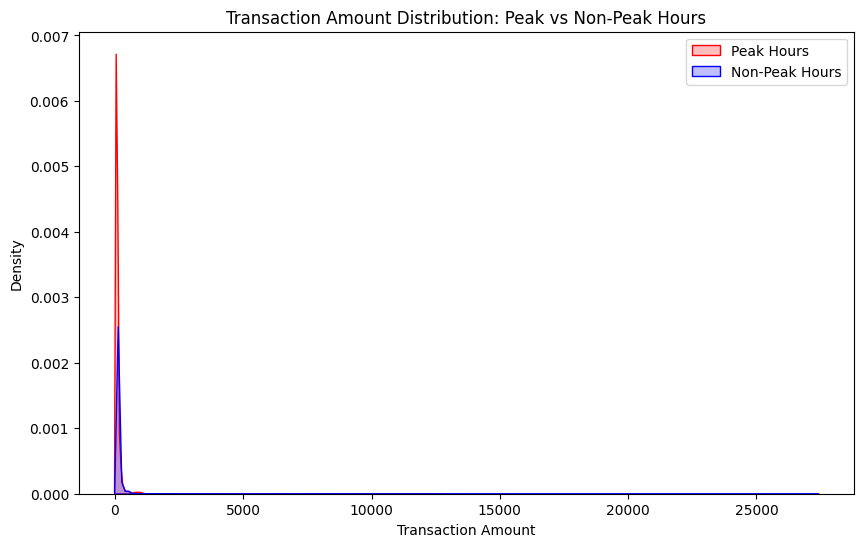

Peak Hours Transaction Amount Stats:
 count    347726.000000
mean         78.612289
std         155.506325
min           1.000000
25%          11.620000
50%          52.690000
75%          88.520000
max       12787.510000
Name: amt, dtype: float64

Non-Peak Hours Transaction Amount Stats:
 count    1.134189e+06
mean     6.738841e+01
std      1.569513e+02
min      1.000000e+00
25%      9.420000e+00
50%      4.570000e+01
75%      8.141000e+01
max      2.739012e+04
Name: amt, dtype: float64


In [25]:
# Define peak fraud hours
peak_hours = [22, 23, 0, 1, 2, 3]

# Separate transactions into peak and non-peak hours
peak_transactions = train[train['trans_hour'].isin(peak_hours)]
non_peak_transactions = train[~train['trans_hour'].isin(peak_hours)]

# Plot distributions of transaction amounts
plt.figure(figsize=(10, 6))
sns.kdeplot(peak_transactions['amt'], fill=True, label='Peak Hours', color='red')
sns.kdeplot(non_peak_transactions['amt'], fill=True, label='Non-Peak Hours', color='blue')
plt.title('Transaction Amount Distribution: Peak vs Non-Peak Hours')
plt.xlabel('Transaction Amount')
plt.legend()
plt.show()

# Statistical comparison
peak_amt_stats = peak_transactions['amt'].describe()
non_peak_amt_stats = non_peak_transactions['amt'].describe()

print("Peak Hours Transaction Amount Stats:\n", peak_amt_stats)
print("\nNon-Peak Hours Transaction Amount Stats:\n", non_peak_amt_stats)

time_zone
Central     0.004902
Eastern     0.005382
Mountain    0.004709
Pacific     0.006145
Name: is_fraud, dtype: float64


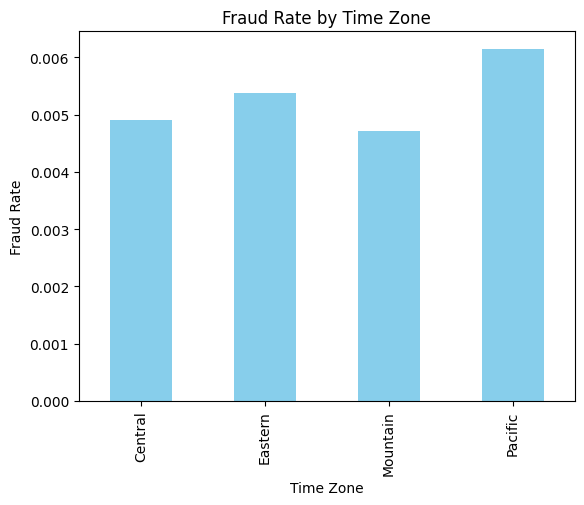

In [32]:
# Create a new feature for time zone based on longitude
def assign_time_zone(longitude):
    if longitude < -120:
        return 'Pacific'
    elif longitude < -105:
        return 'Mountain'
    elif longitude < -90:
        return 'Central'
    else:
        return 'Eastern'

train['time_zone'] = train['long'].apply(assign_time_zone)

# Calculate fraud rate by time zone
fraud_rate_by_time_zone = train.groupby('time_zone')['is_fraud'].mean()
print(fraud_rate_by_time_zone)

# Plot the fraud rate by time zone
fraud_rate_by_time_zone.plot(kind='bar', color='skyblue')
plt.title("Fraud Rate by Time Zone")
plt.xlabel("Time Zone")
plt.ylabel("Fraud Rate")
plt.show()

day_of_week
0    0.003968
1    0.004765
2    0.006100
3    0.006405
4    0.006371
5    0.005657
6    0.004632
Name: is_fraud, dtype: float64


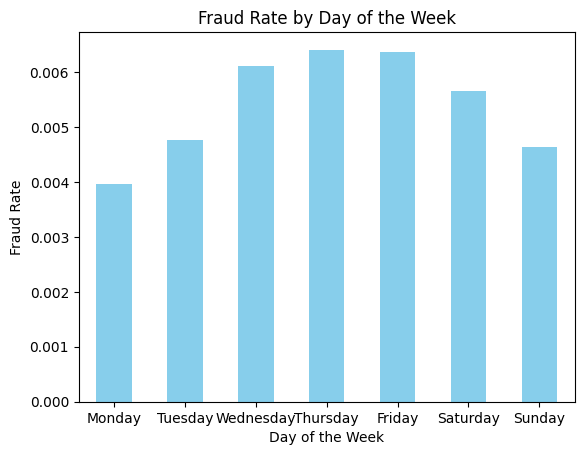

season
Fall      0.005460
Spring    0.006001
Summer    0.004356
Winter    0.005222
Name: is_fraud, dtype: float64


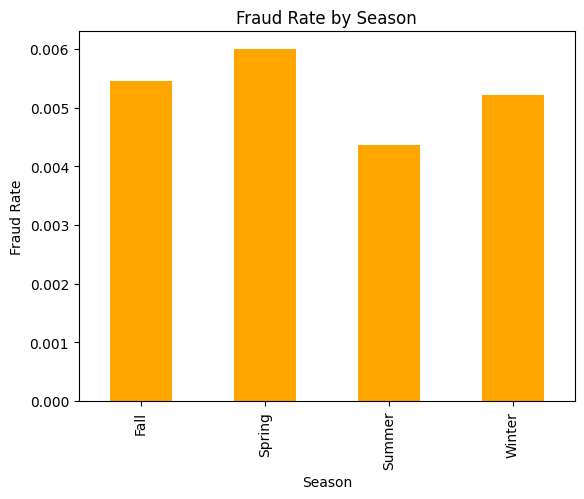

In [27]:
# Convert 'trans_date_trans_time' to datetime format if not already done
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])

# Extract day of the week and season from 'trans_date_trans_time'
train['day_of_week'] = train['trans_date_trans_time'].dt.dayofweek
train['season'] = train['trans_date_trans_time'].dt.month % 12 // 3 + 1

# Map season numbers to season names
season_mapping = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
train['season'] = train['season'].map(season_mapping)

# Calculate fraud rate by day of the week
fraud_rate_by_day_of_week = train.groupby('day_of_week')['is_fraud'].mean()
print(fraud_rate_by_day_of_week)

# Plot the fraud rate by day of the week
fraud_rate_by_day_of_week.plot(kind='bar', color='skyblue')
plt.title("Fraud Rate by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Fraud Rate")
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
plt.show()

# Calculate fraud rate by season
fraud_rate_by_season = train.groupby('season')['is_fraud'].mean()
print(fraud_rate_by_season)

# Plot the fraud rate by season
fraud_rate_by_season.plot(kind='bar', color='orange')
plt.title("Fraud Rate by Season")
plt.xlabel("Season")
plt.ylabel("Fraud Rate")
plt.show()

In [28]:
# Create weekend feature
train['is_weekend'] = train['trans_week'].apply(lambda x: 1 if x in [6, 7] else 0)

# Create night transaction feature
train['is_night'] = train['trans_hour'].apply(lambda x: 1 if x >= 23 or x <= 4 else 0)

# Check fraud rate for new features
weekend_fraud_rate = train.groupby('is_weekend')['is_fraud'].mean()
print("Weekend Fraud Rate:\n", weekend_fraud_rate)

night_fraud_rate = train.groupby('is_night')['is_fraud'].mean()
print("Night Fraud Rate:\n", night_fraud_rate)


Weekend Fraud Rate:
 is_weekend
0    0.005152
1    0.007394
Name: is_fraud, dtype: float64
Night Fraud Rate:
 is_night
0    0.002654
1    0.014509
Name: is_fraud, dtype: float64


In [30]:
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler

# # Select temporal features for clustering
# temporal_features = train[['trans_hour', 'trans_minute', 'trans_second']]
# scaler = StandardScaler()
# temporal_scaled = scaler.fit_transform(temporal_features)

# # Apply DBSCAN
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# train['temporal_cluster'] = dbscan.fit_predict(temporal_scaled)

# # Analyze fraud rate by temporal cluster
# temporal_fraud_rate = train.groupby('temporal_cluster')['is_fraud'].mean()
# print("Fraud Rate by Temporal Cluster:\n", temporal_fraud_rate)


In [31]:
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler

# # Select features for clustering
# features = train[['lat', 'long', 'amt']]

# # Standardize the features
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

# # Apply DBSCAN
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# train['dbscan_labels'] = dbscan.fit_predict(features_scaled)

# # Plot the clusters
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='lat', y='long', hue='dbscan_labels', data=train, palette='viridis', legend='full')
# plt.title('DBSCAN Clustering of Transactions')
# plt.xlabel('Latitude')
# plt.ylabel('Longitude')
# plt.legend(title='Cluster')
# plt.show()

# # Check the distribution of fraud in each cluster
# fraud_distribution = train.groupby('dbscan_labels')['is_fraud'].mean()
# print(fraud_distribution)